In [1]:
import os
import pandas as pd
from tqdm import tqdm

def read_patch_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image patch files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask patch folders
image_patch_folder = "/kaggle/input/training-patches-he-512-idrid/HE_patches - Copy/image_patches_512/"
mask_patch_folder = "/kaggle/input/training-patches-he-512-idrid/HE_patches - Copy/mask_patches_512/"

# Read patch paths and create a DataFrame
df_patches = read_patch_paths(image_patch_folder, mask_patch_folder)

100%|██████████| 1168/1168 [00:37<00:00, 30.75it/s]


In [2]:
df_patches.head()

,Image,Mask
0,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
1,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
2,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
3,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...
4,/kaggle/input/training-patches-he-512-idrid/HE...,/kaggle/input/training-patches-he-512-idrid/HE...


In [3]:
#for multiclass
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask>0
    

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        return  images, masks

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(df_patches, batch_size=8, image_size=(256, 256), shuffle=True)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


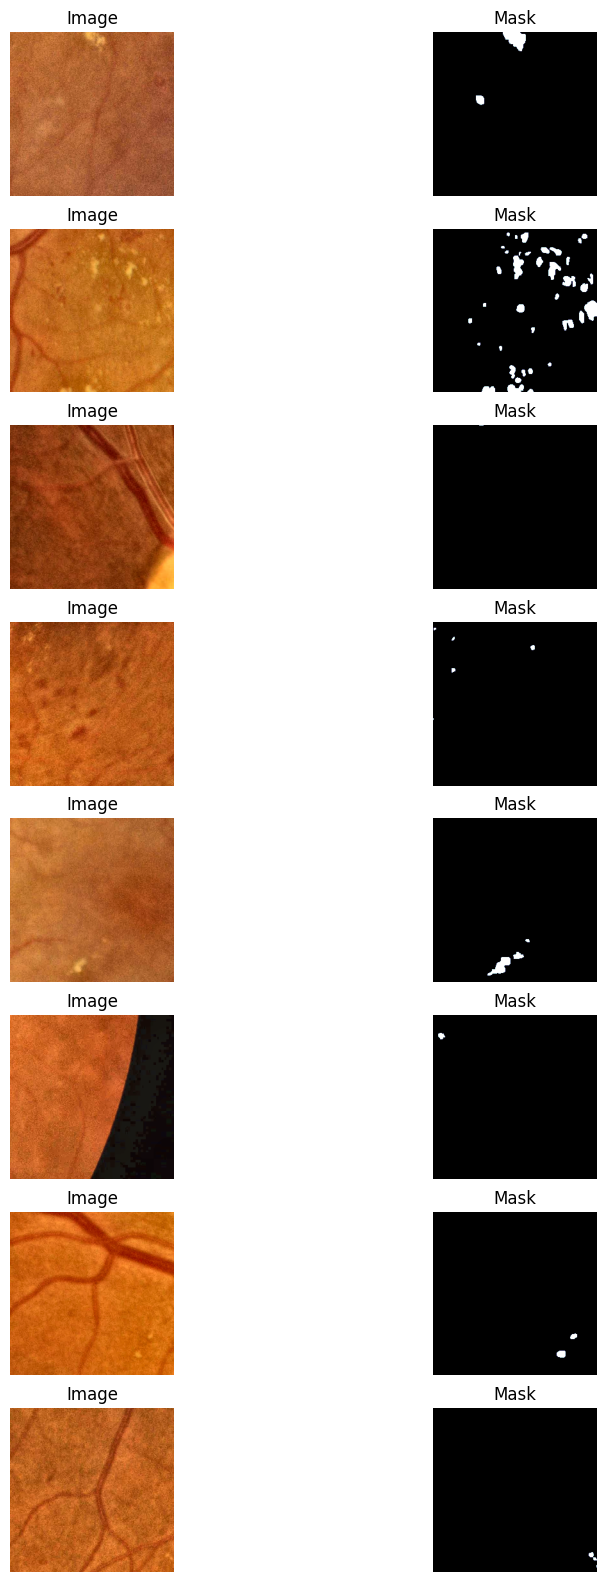

In [4]:
import matplotlib.pyplot as plt

# Load a single batch
batch = train_generator[0]  # Assuming you want to load the first batch

# Extract images and labels from the batch
images, masks = batch

# Display the images and masks
n_images_to_display = len(images)
fig, ax = plt.subplots(n_images_to_display, 2, figsize=(10, 20))
for i in range(n_images_to_display):
    ax[i, 0].imshow(images[i], cmap='bone')
    #print(np.max(images[i]))
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(masks[i], cmap='bone')
    #print(np.max(masks[i]))
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split

df_shuffled = df_patches.sample(frac=1, random_state=42)
train_df, val_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)

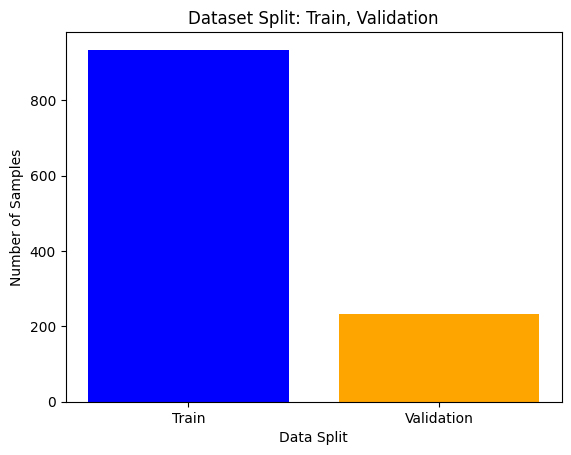

In [8]:
# bar plot
from matplotlib import pyplot as plt
sizes = [len(train_df), len(val_df)]
labels = ['Train', 'Validation']

plt.bar(labels, sizes, color=['blue', 'orange'])
plt.xlabel('Data Split')
plt.ylabel('Number of Samples')
plt.title('Dataset Split: Train, Validation')
plt.show()

# Model Architecture and Helper blocks

In [14]:
#GCSE Block...from the GCSER UNET (Mukherjee et al.)
def GCSE(input_tensor, ratio=16):


    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)

    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu')(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid')(attn_channel)

    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(global_info)

    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply()([attn_channel,attn_spatial])

    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply()([input_tensor,attn])

    return output_tensor

In [15]:
def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=3, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=5, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=7, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [16]:
from tensorflow.keras.applications import VGG16
def build_encoder2(inputs):

    s=[]
    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in vgg16.layers:
        layer.trainable = True

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s.append(s1)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s.append(s2)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s.append(s3)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)
    s.append(s4)

    """ Bridge """
    b = vgg16.get_layer("block5_conv3").output         ## (32 x 32)
    b = ASPP(b,128)
    
    encoder2 = Model(inputs,outputs=[s,b],name = "encoder2")

    return encoder2

# Symmetric architecture

In [17]:
# Code for W-Net

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model


def complementary_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.math.sigmoid(mse_loss)


def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    #x = Activation("relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)


    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, s1,s2, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x,s1,s2])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x
def build_encoder1(inputs,f):
    
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    c1 = GCSE(c1)
    p1 = MaxPooling2D((2,2))(c1)
    s1 = c1

    c2 = residual_block(p1, f[1])
    c2 = GCSE(c2)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = c2

    c3 = residual_block(p2, f[2])
    c3 = GCSE(c3)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = GCSE(c4)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = c4
    
    s_ = [s1,s2,s3,s4]
    """ Bridge """
    b = ASPP(p4,128)
    encoder1 = Model(inputs,outputs=[s_,b],name="encoder1")
    return encoder1

    
    

def build_WNet(input_shape):
    f = [64,128,256,512]

    inputs = Input(input_shape,name="model_input")
    encoder1 = build_encoder1(inputs,f)
    encoder2 = build_encoder2(inputs)
    s1,b1 = encoder1(inputs)
    s2,b2 = encoder2(inputs)

    b = Concatenate()([b1,b2])

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s2[3],s1[3], f[3])
    d2 = decoder_block(d1, s2[2],s1[2], f[2])
    d3 = decoder_block(d2, s2[1],s1[1], f[1])
    d4 = decoder_block(d3, s2[0],s1[0],f[0])
    
    comp1 = complementary_loss(s2[0], s1[0])
    comp2 = complementary_loss(s2[1], s1[1])
    comp3 = complementary_loss(s2[2], s1[2])
    comp4 = complementary_loss(s2[3], s1[3])
    comp5 = complementary_loss(b1, b2)
    

    output_2 = tf.keras.layers.Add(name='output_2')([comp3,comp4,comp5])

    """ Classifier """
    output_1 = Conv2D(1, (1,1) , activation="sigmoid",name='output_1')(d4)

    """ Model """
    model = Model(inputs,outputs=[output_1,output_2])
    return model

# Asymmetric Architecture

In [18]:
# Code for W-Net

from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error


def complementary_loss(feature_map1,feature_map2):
    # Normalize the feature maps to [0, 1]
    feature_map1 /= tf.reduce_max(feature_map1)
    feature_map2 /= tf.reduce_max(feature_map2)
    m1 = tf.reduce_mean(feature_map1)
    m2  = tf.reduce_mean(feature_map2)

    return tf.math.sigmoid(tf.abs(m1-m2))


def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    #x = Activation("relu")(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)


    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, s1,s2, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x,s1,s2])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x
def build_encoder1(inputs,f):
    
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    c1 = GCSE(c1)
    p1 = MaxPooling2D((2,2))(c1)
    s1 = c1

    c2 = residual_block(p1, f[1])
    c2 = GCSE(c2)
    p2 = MaxPooling2D((2,2))(c2)
    s2 = c2

    c3 = residual_block(p2, f[2])
    c3 = GCSE(c3)
    p3 = MaxPooling2D((2,2))(c3)
    s3 = c3

    c4 = residual_block(p3, f[3])
    c4 = GCSE(c4)
    p4 = MaxPooling2D((2,2))(c4)
    s4 = c4
    
    s_ = [s1,s2,s3,s4]
    """ Bridge """
    b = ASPP(p4,128)
    encoder1 = Model(inputs,outputs=[s_,b],name="encoder1")
    return encoder1

    
    

def build_WNet(input_shape):
    f = [16,32,64,128]

    inputs = Input(input_shape,name="model_input")
    encoder1 = build_encoder1(inputs,f)
    encoder2 = build_encoder2(inputs)
    s1,b1 = encoder1(inputs)
    s2,b2 = encoder2(inputs)

    b = Concatenate()([b1,b2])

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s2[3],s1[3], f[3]+512)
    d2 = decoder_block(d1, s2[2],s1[2], f[2]+256)
    d3 = decoder_block(d2, s2[1],s1[1], f[1]+128)
    d4 = decoder_block(d3, s2[0],s1[0],f[0]+64)
    
    """comp1 = complementary_loss(s2[0], s1[0])
    comp2 = complementary_loss(s2[1], s1[1])
    comp3 = complementary_loss(s2[2], s1[2])
    comp4 = complementary_loss(s2[3], s1[3])
    comp5 = complementary_loss(b1, b2)
    

    output_2 = tf.keras.layers.Add(name='output_2')([comp1/4.0,comp2/4.0,comp3/4.0,comp4/4.0])"""

    """ Classifier """
    output_1 = Conv2D(1, (1,1) , activation="sigmoid",name='output_1')(d4)

    """ Model """
    #model = Model(inputs,outputs=[output_1,output_2])
    model = Model(inputs,outputs=output_1)
    return model

# Evaluation Metrics

In [19]:
from keras import backend as K
import tensorflow as tf
epsilon = 1e-5
smooth = 1e-5

def dice_coeff(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return  1- dice_coeff(y_true, y_pred, smooth=1e-5)

def FocalLoss(targets, inputs, alpha=0.25, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-5) / (union + 1e-5)
    return iou


# Fine-tuning Joint updation

Im going for this method instead...more efficient

In [20]:
model = build_WNet((256,256,3))

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=total_loss,           
              metrics = {"output_1":[iou_score,dice_coeff,tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),sensitivity,specificity,tf.keras.metrics.AUC()]})


In [23]:
model.get_layer("encoder1").trainable = True
model.get_layer("encoder2").trainable = True

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('/kaggle/working/training_log_WCE_segmentation', separator=',', append=True)
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=6
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="/kaggle/working/WNet_maxpool_fine_tune.h5", 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
                              
"""reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=4,
                              min_delta=0.000001,
                              factor=0.3
                             )"""
callbacks = [checkpointer, reduce_lr, csv_logger, earlystopping]

In [ ]:
batch_size = 4
N = 256
train_generator = CustomDataGenerator(train_df, batch_size=batch_size, image_size=(N,N), shuffle=True)
val_generator = CustomDataGenerator(val_df, batch_size=batch_size, image_size=(N,N), shuffle=False)
history_ = model.fit(train_generator, steps_per_epoch=len(train_df) // batch_size,
                    validation_data=val_generator, validation_steps=len(val_df) // batch_size,
                    epochs=50,callbacks=callbacks)

Epoch 1/50


2024-01-19 14:45:27.460178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/encoder1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 [==============================] - ETA: 0s - loss: 0.6075 - iou_score: 0.2138 - dice_coeff: 0.4179 - precision_1: 0.4931 - recall_1: 0.4778 - sensitivity: 0.4736 - specificity: 0.9855 - auc_1: 0.8455
Epoch 1: val_loss improved from inf to 0.54597, saving model to /kaggle/working/WNet_maxpool_fine_tune.h5
233/233 [==============================] - 121s 327ms/step - loss: 0.6075 - iou_score: 0.2138 - dice_coeff: 0.4179 - precision_1: 0.4931 - recall_1: 0.4778 - sensitivity: 0.4736 - specificity: 0.9855 - auc_1: 0.8455 - val_loss: 0.5460 - val_iou_score: 0.2714 - val_dice_coeff: 0.4784 - val_precision_1: 0.5293 - val_recall_1: 0.6303 - val_sensitivity: 0.5580 - val_specificity: 0.9845 - val_auc_1: 0.8974 - lr: 1.0000e-04
Epoch 2/50
233/233 [==============================] - ETA: 0s - loss: 0.4509 - iou_score: 0.3167 - dice_coeff: 0.5716 - precision_1: 0.7058 - recall_1: 0.6032 - sensitivity: 0.5975 - specificity: 0.9925 - auc_1: 0.8878
Epoch 2: val_loss improved from 0.54597 to 0.

the kernel didnt die....got the output files...i think it kept running in the background

In [13]:
# Save the final trained model
model.save('final_model_fine_tuned.h5')

NameError: name 'model' is not defined

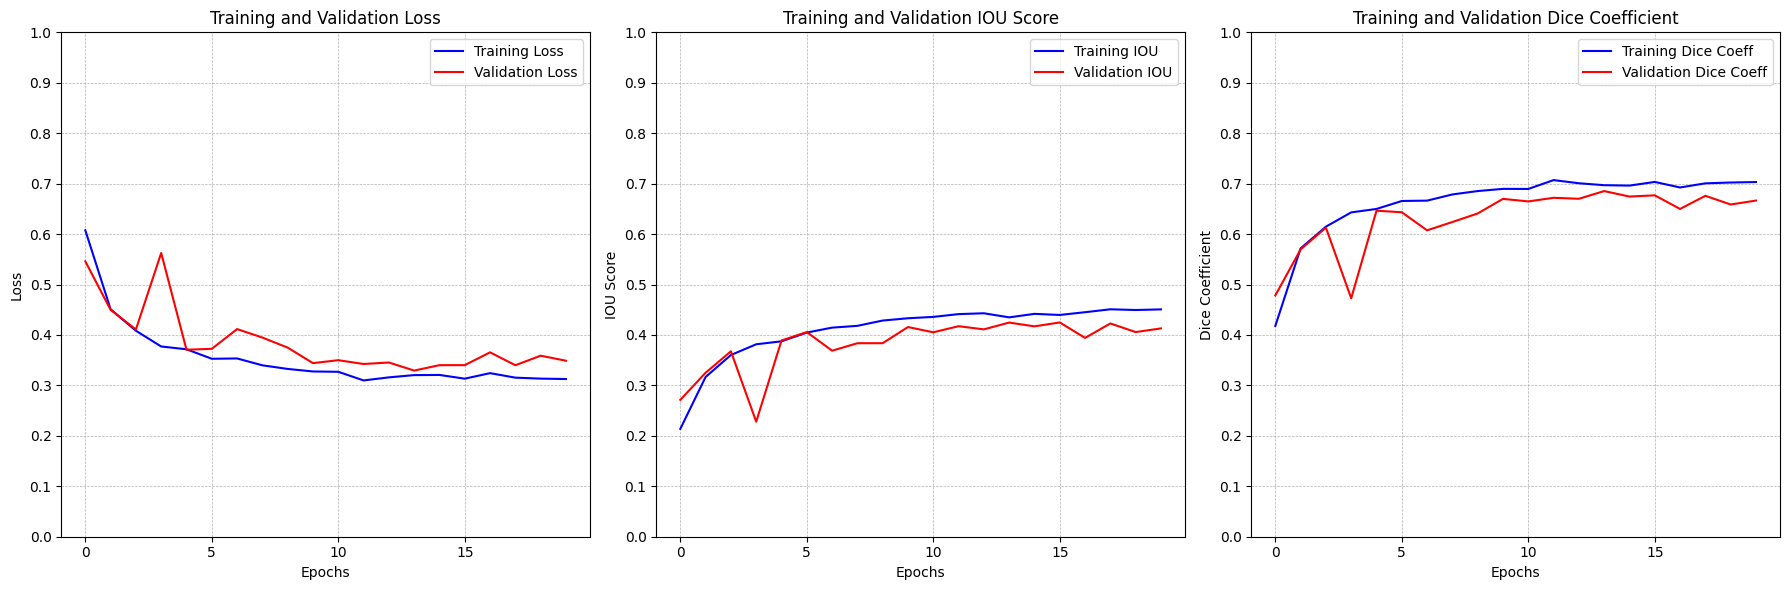

In [28]:
from matplotlib import pyplot as plt
history = pd.read_csv('/kaggle/working/training_log_WCE_segmentation', sep=',', engine='python')

#history= history

############### ########## ####### #######

iou_score=history['iou_score']
val_iou_score=history['val_iou_score']

loss=history['loss']
val_loss=history['val_loss']

train_dice=history['dice_coeff']
val_dice=history['val_dice_coeff']



epoch = np.arange(len(loss))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Plot 1: Loss
axes[0].plot(epoch, loss, 'b', label='Training Loss', linewidth=1.5)
axes[0].plot(epoch, val_loss, 'r', label='Validation Loss', linewidth=1.5)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot 2: IOU Scores
axes[1].plot(epoch, iou_score, 'b', label='Training IOU', linewidth=1.5)
axes[1].plot(epoch, val_iou_score, 'r', label='Validation IOU', linewidth=1.5)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('IOU Score')
axes[1].set_title('Training and Validation IOU Score')
axes[1].legend()

# Plot 3: Dice Coefficients
axes[2].plot(epoch, train_dice, 'b', label='Training Dice Coeff', linewidth=1.5)
axes[2].plot(epoch, val_dice, 'r', label='Validation Dice Coeff', linewidth=1.5)
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Dice Coefficient')
axes[2].set_title('Training and Validation Dice Coefficient')
axes[2].legend()


# Customize tick marks and labels
for ax in axes:
    ax.grid(True)
    ax.set_xticks(np.arange(0, len(epoch), 5))  # Adjust the x-axis ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))  # Adjust the y-axis ticks
    ax.grid(which='both', linestyle='--', linewidth=0.5)

# Display the plots
plt.tight_layout()
plt.show()

# Preparing Testing Data

In [29]:
import os
import pandas as pd
from tqdm import tqdm

def read_patch_paths(image_folder, mask_folder):
    image_paths = []
    mask_paths = []

    # Get a list of image patch files in the folder
    image_files = os.listdir(image_folder)

    # Assuming the file names are the same in the mask folder
    for file_name in tqdm(image_files):
        image_path = os.path.join(image_folder, file_name)
        mask_path = os.path.join(mask_folder, file_name)

        # Check if both image and mask paths exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image_paths.append(image_path)
            mask_paths.append(mask_path)

    # Create a DataFrame
    df = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
    return df

# Specify the paths to the image and mask patch folders
image_patch_folder = "/kaggle/input/testing-patches-he-512-idrid/HE_patches_test/image_patches_512_no_overlap"
mask_patch_folder = "/kaggle/input/testing-patches-he-512-idrid/HE_patches_test/mask_patches_512_no_overlap"

# Read patch paths and create a DataFrame
df_patches_test = read_patch_paths(image_patch_folder, mask_patch_folder)

100%|██████████| 456/456 [00:11<00:00, 40.53it/s]


In [31]:

import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return clahe_image

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            #A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for i, row in batch_df.iterrows():

            image = cv2.imread(row['Image'], cv2.IMREAD_COLOR)
            image = apply_clahe(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/np.max(image)
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask>0
    

            #augmented = self.transform(image=image, mask=mask)
            #images.append(augmented['image'])
            #masks.append(augmented['mask'])
            images.append(image)
            masks.append(mask)
        
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        return  images, masks

# Example usage of the CustomDataGenerator
test_generator = CustomDataGenerator(df_patches_test, batch_size=16, image_size=(256, 256), shuffle=False)

In [32]:
results = model.evaluate(test_generator)

29/29 [==============================] - 25s 586ms/step - loss: 0.2770 - iou_score: 0.4416 - dice_coeff: 0.7421 - precision_1: 0.7163 - recall_1: 0.8290 - sensitivity: 0.8220 - specificity: 0.9889 - auc_1: 0.9571


In [33]:
!zip -r weights_WNet_VGG16.zip /kaggle/working/WNet_maxpool_fine_tune.h5

  adding: kaggle/working/WNet_maxpool_fine_tune.h5 (deflated 8%)


In [34]:
from IPython.display import FileLink
FileLink(r'weights_WNet_VGG16.zip')

/kaggle/working/weights_WNet_VGG16.zip